<p/>
<p style="font-size:48px; font-weight: bolder; text-align: center"> Constant-pressure (PI)MD </p>
<p style="font-size:18px; text-align: center"><i> authored by:  Hannah Bertschi, Jorge Castro, George Trenins </i></p>
<p style="font-size:18px; text-align: center"><i> adapted from <a href="https://github.com/i-pi/piqm2023-tutorial" target="_blank">tutorials for the PIQM-2023 Advanced School</a></i></p>_

In this tutorial we explore molecular dynamics simulations at constant temperature and pressure. Using the [i-PI package](https://ipi-code.org) we will perform classical molecular dynamics (MD) and path-integral molecular dynamics (PIMD) simulations of low-temperature, high-pressure solid hydrogen. By the end, you will learn to set up thermostats and barostats in i-PI, how to restart simulations from checkpoint files, and how to visualize the output data using [chemiscope](https://atomistic-cookbook.org/software/chemiscope.html). You will also see the substantial impact of *thermal quantum swelling* on the equilibrium density of solid hydrogen.

# Simulation cell

To simulate *bulk* hydrogen we set up a "supercell" containing 108 hydrogen molecules subject to periodic boundary conditions. This eliminates surface effects, however the (PI)MD simulations may instead be influenced by correlation between different *images* of the supercell not present in the physical bulk material. It is important to monitor such finite-size effects in production calculations by comparing simulation results for different supercell sizes. On this occasion we will be skipping this step in the interest of time.

<figure style="text-align: center;">
  <img src="images/pbc.svg" alt="3-by-3 tiling of a 2D supercell" style="width:400px;">
  <figcaption style="font-style: italic; font-size: 90%;">Two-dimensional supercell (grey) containing three particles (blue). The dynamics are performed under periodic boundary, and the forces on the supercell include interactions with its periodic replicas or "images" (greyscale, only the nearest neighbours are shown).</figcaption>
</figure>

In [1]:
# Load and display the initial supercell
from ase.io import read
from ase import Atoms
import chemiscope
structure: Atoms = read('classical/para-h2.pdb')
chemiscope.show(
    frames=[structure], mode="structure",
    settings=chemiscope.quick_settings(
        structure_settings={
            "atoms": True,
            "spaceFilling": True,
            "unitCell": True})
)

<StructureWidget(meta={'name': ' '}, settings={'map': {'joinPoints': False}, 'structure': [{'keepOrientation':…

# Temperature and pressure control

We want to impose a constant external pressure and temperature. In other words, we sample the isothermal-isobaric ensemble,

$$
\mathcal{P}_\mathrm{NPT}(\mathbf{q},\mathbf{p}, V)\propto \exp(-\beta(E(\mathbf{q}, \mathbf{p})+P_\mathrm{ext}V)).
$$  

In this example, the external pressure is set to 50 MPa and the temperature to 33 K. 
The temperature and pressure are controlled by a thermostat and a barostat, respectively. We consider only one of the (many) options implemented in i-PI. In this implementation, the dynamics are defined by the following equations, discussed in [M. Ceriotti et al., Comput. Phys. Commun. 185, 1019-1026 (2014)](https://doi.org/10.1016/j.cpc.2013.10.027).  

$$
\begin{split}
\dot{p}=&-\partial U/\partial q \color{blue}{-\alpha p/\mu} \color{red}{-\gamma_p p + b_p \xi(t)}\\
\dot{q}=&\frac{p}{m} \color{blue}{+\alpha q/\mu}\\
\dot{V}=&\color{blue}{3V\alpha/\mu}\\
\dot{\alpha}=&\color{blue}{3\left[V\left(P_\mathrm{int}-P_\mathrm{ext}\right)+2k_{B}T\right]} \color{red}{- \gamma_\alpha \alpha + b_\alpha \chi(t)}\\
\end{split}
$$

The expressions shown in **black** describe propagation of the momenta $p$ and positions $q$ in a potential $U(q)$ under Hamilton's equations of motion. The resulting dynamics conserve the microcanonical distribution, i.e., 
the particle number $N$, the total energy $E$, and the cell volume $V$ remain constant. To simulate the response to an external pressure $P_\text{ext}$, we include the terms in 
<b><span style="color: blue;">blue</span></b>. The terms in <b><span style="color: red;">red</span></b> simulate energy exchange with a heat bath at a constant temperature $T$.

## Pressure control with a barostat

The cell volume $V$ is a dynamical variable, with an associated fictitious mass $\mu$ and momentum $\alpha$ [1]. The factor $\alpha / \mu$ determines how much the volume $V$ is scaled per time unit. When the volume of the cell changes, the positions $q$ are scaled by the same factor, while the momenta are scaled by its reciprocal, so that the phase-space volume element remains constant,

$$
\mathrm{d}q_{t} \mathrm{d}p_{t} = \mathrm{d}q_{0} \mathrm{d}p_{0}. 
$$

If the internal pressure $P_\text{int}$ [2] is larger than the target pressure $P_\text{ext}$, then $\dot{\alpha} > 0 $ and the cell expands. The opposite is true if the internal pressure is smaller than $P_\text{ext}$. This ensures that, upon equilibration, the internal pressure fluctuates about $P_\text{ext}$. The equilibration time scale $\tau$ is related to the number of atoms $n$ and the fictitious mass $\mu$, 
$$
\tau = \sqrt{\beta \mu / 3 n} \qquad \text{where} \qquad \beta = 1/k_{\text{B}} T.
$$

<figure style="text-align: center;">
  <img src="images/NPH.svg" alt="A simulation cell under extrenal pressure from an isotropic piston" style="width:400px;">
  <figcaption style="font-style: italic; font-size: 90%;">An "isotropic piston" (orange arrows) applies external pressure to the simulation cell (red). This is counteracted by the system's internal pressure (blue arrows), and the dynamics of the cell volume are determined by the balance of the two.</figcaption>
</figure>

The barostat in this example is well suited to simulations of liquids and isotropic solids, but [other options](https://docs.ipi-code.org/input-tags.html#barostat) are also available in i-PI. 

<p style="color:#616161; font-size: 90%">[1] Technically $\alpha$ is the conjugate momentum of the dynamical variable $\ln(s)$, where $s$ is a uniform factor scaling each of the supercell vectors, such that at time $t$, the cell volume is $ V(t) = s^3(t) V(0)$.</p>

<p style="color:#616161; font-size: 90%">[2] Calculated as
$P_{\text{int}} = \frac{1}{3V}\sum_{i = 1}^{N} \left\{\frac{|\mathbf{p}_i|^2}{m_i} - \mathbf{q}_i \cdot \frac{\partial U}{\partial \mathbf{q}_i} \right\} $.
</p>

## Temperature control with a thermostat

Adding only the <b><span style="color: blue;">blue</span></b> terms does not impose a constant temperature, but rather a constant enthalpy, $H$ [[G. Bussi et al., J. Chem. Phys. 130, 074101 (2009)](https://doi.org/10.1063/1.3073889)], so that the  dynamics samples the isoenthalpic-isobaric (NPH) ensemble. In canonical (NVT) ensemble simulations, temperature is controlled by a thermosat. We can let a thermostat act on the particles *as well as* the cell volume (terms in <b><span style="color: red;">red</span></b> ), which "upgrades" the simulation to NPT.

<figure style="text-align: center;">
  <img src="images/NPT.svg" alt="A simulation cell under extrenal pressure from an isotropic piston" style="width:800px;">
  <figcaption style="font-style: italic; font-size: 90%;">A specially designed combination of constant-pressure (NPH) and constant-temperature (NVT) dynamics results in a constant-pressure, constant-temperature (NPT) simulation.</figcaption>
</figure>

The Langevin thermostat modifies the momenta via the friction term $\textcolor{red}{-\gamma p}$, where the friction coefficient is related to the *thermostat time scale*
$
\tau = 1/\gamma.
$
The thermostat also contains a random force term $\textcolor{red}{b \xi (t)}$, generated by a
Gaussian random variate with zero mean $\langle \xi \rangle = 0$ and with covariance $\langle \xi(t) \xi(t') \rangle = \delta(t-t')$. To impose a temperature $T$, the random term is scaled by $b = \sqrt{2 \gamma k_{\text{B}} T}$.

# Setting up an NPT calculation

We will use the para-hydrogen potential from [I. Silvera and V. Goldman, J. Chem. Phys., 69, 4209 (1978)](https://doi.org/10.1063/1.437103) implemented in i-PI's FORTRAN driver. The simulations is performed at 33 K, where substantial nuclear quantum effects are expected. To verify that this is indeed the case, we begin by running a purely classical (MD) simulation. 

## Input file

Inputs to run molecular dynamics in the constant-pressure ensemble can be found in the `classical` folder. You will find a `para-h2.pdb` file that contains the starting positions of the atoms, and `npt-md.xml`, the actual i-PI input. Let's have a look at them.

### Property output

The first section of the file defines the logging level (`verbosity='medium'`), the content of output files, (see [official documentation](https://docs.ipi-code.org/output-files.html#properties) for full list) and the total number of simulation steps that should be run.

```xml
<simulation verbosity='medium'>
  <output prefix='ph2-npt-md'>
    <properties filename='md' stride='10'> [step, time{picosecond}, conserved{electronvolt}, 
                                            temperature{kelvin}, potential{electronvolt}, kinetic_md{electronvolt}, 
                                            pressure_md{megapascal}, volume{angstrom3}] 
    </properties>
    <trajectory filename='pos' stride='100' format='pdb' cell_units='angstrom'> positions{angstrom} </trajectory>
    <checkpoint filename='checkpoint' stride='1000' overwrite='True'/>
  </output>
  <total_steps> 10000 </total_steps>
    ...
</simulation>

### Forcefield

Next comes the definition of the forcefield. i-PI is designed to propagate nuclear coordinates, while an external program evaluates the forces that drive the dynamics. As a bare minimum, i-PI must communicate the changing nuclear positions to the external program, and the program must in return communicate the corresponding energy and forces. This [communication](https://docs.ipi-code.org/distributed.html#communication-protocol) is realised via sockets, which come in two types: UNIX and TCP/IP. Today we will be using the faster but less versatile UNIX socket,

```xml
<simulation verbosity='medium'>
    ...
    <ffsocket mode='unix' name='ph2-ff'>
        <address> ph2-driver</address>
    </ffsocket>
    ...
</simulation>
```

The `<address>` tag specifies the socket name, while the `name` attribute specifies how this forcefield is referred to in the `<system><forces>...</forces></system>` section of the input file (see below).

### System

The `<system>` tag defines everything that is system-related. `<initialize>` specifies where to fetch the initial atomic positions and cell size, while `<velocities>` instructs i-PI on how to initialize the particle momenta. We have to specify that the temperature is in Kelvin, otherwise i-PI assumes that it is provided in atomic units.

```xml
<simulation verbosity='medium'>
    ...
    <system>
        <initialize nbeads='1'>
            <file mode='pdb'> para-h2.pdb </file>
            <velocities mode='thermal' units='kelvin'> 33 </velocities>
        </initialize>
        <forces>
            <force forcefield='ph2-ff'/>
        </forces>
        <ensemble>
            <temperature units='kelvin'> 33 </temperature>
            <pressure units='megapascal'> 50 </pressure>
        </ensemble>
        ...
    </system>    
</simulation>
```

`<forces>` specifies how to construct interactions. In this case, we simply fetch them from the single forcefield we defined above, but we shall see how more complicated setups can be realized. 
Finally, `<ensemble>` defines the parameters of the distribution sampled by the dynamics: in this case, a temperature of 33 K and pressure of 50 MPa. 

### Dynamics

The way the position of the atoms should be evolved is specified in the `<motion>` section. In this case, we run molecular dynamics in the `npt` ensemble, which means that in addition to the integration `timestep`, we need to specify a `<thermostat>` and a `<barostat>`. The first `thermostat` keyword controls the thermostat acting on the momenta $p$ of the atoms. This is followed by a barostat section, which has its own thermostat controlling the fictitious cell momentum $\alpha$.

```xml
<simulation verbosity='medium'>
    ...
    <system>
        ...
        <motion mode='dynamics'>
            <dynamics mode='npt'>
                <timestep units='femtosecond'> 1 </timestep>
                <thermostat mode='pile_g'>
                    <tau units='femtosecond'> 25 </tau>
                </thermostat>
                <barostat mode='isotropic'>
                    <tau units='femtosecond'> 250 </tau>
                    <thermostat mode='langevin'>
                        <tau units='femtosecond'> 50 </tau>
                    </thermostat>
                </barostat>
            </dynamics>
        </motion>
    </system>
</simulation>
```

## Running the simulation

To run the calculation, starting from the root directory perform the following:

```bash
# change to directory containing the i-pi inputs for the classical simulation
cd 01-constant-pressure/classical
# run the launcher script
./run_md.sh
```
The script `run_md.sh` contains two parts:
- launch the i-pi server
```bash
python -u $(which i-pi) npt-md.xml &> log.md &
```
- launch the force-field client
```bash
i-pi-driver -u -a ph2-driver -m sg -o 15 -v &> log.driver &
```

The simulation will finish in a few seconds, and you can monitor its progress via
```bash
tail -f log.md
```
(press <kbd>Ctrl</kbd> + <kbd>C</kbd> to stop "tailing").

## Visualizing and analyzing results

We use some utility functions to read the output of i-PI and visualize it. Note the fast equilibration of the cell volume, and how the pressure estimator converges to the target value. 

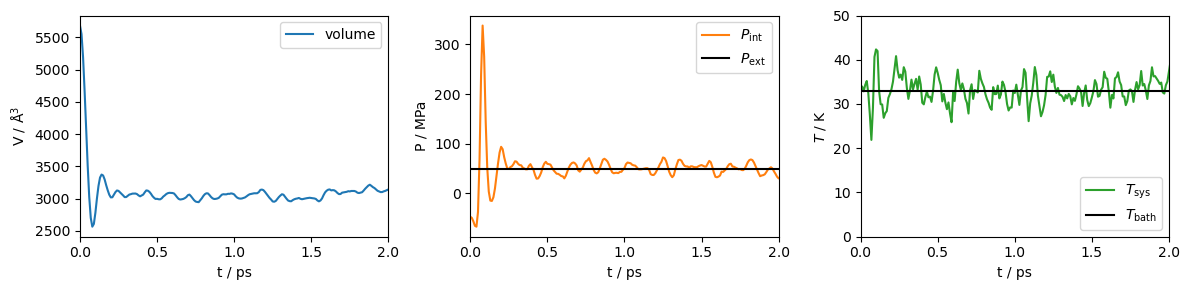

In [2]:
from ipitools.io_ipi import read_ipi_output
import matplotlib.pyplot as plt
from pathlib import Path
datadir = Path("classical")  # change to "output" to load reference data
md_output = read_ipi_output(datadir/'ph2-npt-md.md')
fig, ax = plt.subplots(1,3,figsize=(12,3),sharex=True)
# Simulation cell volume
ax[0].plot(md_output["time"], md_output["volume"], 'C0-', label="volume")
ax[0].set_xlabel("t / ps")
ax[0].set_ylabel("V / Å$^3$")
ax[0].legend()
# Internal and external pressure
ax[1].plot(md_output["time"], md_output["pressure_md"], 'C1-', label=r'$P_\text{int}$')
ax[1].axhline(y=50, color='k', label=r'$P_\text{ext}$')
ax[1].set_xlabel("t / ps")
ax[1].set_ylabel(r"P / MPa")
ax[1].legend()
# (Kinetic) temperature
ax[2].plot(md_output["time"], md_output["temperature"], 'C2-', label=r'$T_\text{sys}$')
ax[2].axhline(y=33, color='k', label=r'$T_\text{bath}$')
ax[2].set_xlabel("t / ps")
ax[2].set_ylabel(r"$T$ / K");
ax[2].set_ylim([0, 50])
ax[2].legend(loc=4)
# Plot the first 2 ps of the dynamics; equilibration is very fast
ax[2].set_xlim([0,2])
plt.tight_layout()

The internal pressure $P_\text{int}$ equilibrates towards the specified external pressure of 50 MPa within about 250 fs, which is the specified time constant $\tau$ of the barostat. We can also use `chemiscope` to visualize the trajectory. Notice the rapid equilibration of the supercell. 

In [3]:
## loads structures, discarding unused atom properties
import warnings
warnings.filterwarnings('ignore', '.*residuenumbers array.*')
frames = read(datadir/'ph2-npt-md.pos_0.pdb', ":")
for f in frames:
    f.info = {}
    f.arrays = {'positions': f.positions,  'numbers': f.numbers}
# Particle coordinates are printed every 100 steps, potential energy and volume -- every 10.
# To match PDB frames to numerical data, use every 10th data point.
stride=10
chemiscope.show(frames=frames, 
                     properties={
                         "t" : { "values":  md_output["time"][::stride], "units": "ps", "target":"structure"},
                         "U" : { "values":  md_output["potential"][::stride], "units": "eV", "target":"structure"},
                         "V" : { "values":  md_output["volume"][::stride], "units": r"Å", "target":"structure"}
                     },
                     settings = {
                         'structure': [{ 'keepOrientation': True, 
                                         'unitCell': True,
                                         "spaceFilling": False,
                                         'playbackDelay': 20}],
                        'map': {'x': {'max': 10,  'min': -0.1, 'property': 't', 'scale': 'linear'},
                                'y': {'max': 5800,  'min': 2500, 'property': 'V', 'scale': 'linear'},
                                 'color': {'property': 'U'}
                               }
                     })

<ChemiscopeWidget(meta={'name': ' '}, settings={'structure': [{'keepOrientation': True, 'unitCell': True, 'spa…

# Constant-pressure path integrals

Systems such as para-hydrogen at cryogenic temperatures exhibit large quantum effects, which affect their thermodynamic properties, and in particular their equations of state. Performing NPT simulation with quantum nuclei in i-PI is really simple: the supercell volume is not quantized, and thus $\alpha$ and $V$ are treated with the same equations of motion as shown above. Every atom is replaced by a ring polymer; the internal pressure is calculated as before, except all classical quantities are replaced by the momenta, positions and forces of the corresponding *ring-poymer centroids*. The centroids are propagated according to equations of motion that are exactly analogous to the classical case. 

<figure style="text-align: center;">
  <img src="images/rp.svg" alt="A simulation cell under extrenal pressure from an isotropic piston" style="width:500px;">
  <figcaption style="font-style: italic; font-size: 90%;">A ring polymer (left) can either be described in terms of beads or in terms of collective normal-mode coordinates (right). The "zero-frequency" coordinate is called the centroid and is just an average over the beads. The fluctuation coordinates describe internal distortions of ring polymer away from the collapsed equilibrium geometry.</figcaption>
</figure>

The ring-polymer *fluctuation modes* are only coupled to their own thermostats: there is no direct coupling to a barostat.
You can read more about the theory and the implementation in the paper that accompanied the first release of i-PI [[M. Ceriotti, J. More, and D. E. Manolopoulos, Comp. Phys. Comm. 185(3), 1019–1026 (2014)](https://doi.org/10.1016/j.cpc.2013.10.027)].

## Input file

There is very little that needs to be changed in the input file. Starting from the root directory of the tutorial, execute

```bash
cd 01-constant-pressure
cp classical/npt-md.xml pimd/npt-pimd.xml
cp classical/RESTART pimd/classical-RESTART
cd pimd
```

We use the i-PI input file from the classical simulation above as a starting point for the PIMD input file. Additionally, the `RESTART` file generated at the end of the MD simulation is copied over. Using a text editor of your choosing open the `npt-pimd.xml` file and modify the highlighted parts of the `output` block
<pre><code>
&lt;output <span style="background-color: yellow;">prefix='ph2-npt-pimd'</span>&gt;
    &lt;properties filename='md' stride='10'&gt; [step, time{picosecond}, conserved{electronvolt}, 
                                            temperature{kelvin}, potential{electronvolt}, kinetic_md{electronvolt}, 
                                            <span style="background-color: yellow;">kinetic_cv{electronvolt}, pressure_cv{megapascal}</span>, volume{angstrom3}] 
    &lt;/properties&gt;
    &lt;trajectory filename='pos' stride='100' format='pdb' cell_units='angstrom'&gt; positions{angstrom} &lt;/trajectory&gt;
    &lt;checkpoint filename='checkpoint' stride='1000' overwrite='True'/&gt;
&lt;/output&gt;
</code></pre>

We will also change the socket address
<pre><code>
&lt;ffsocket mode='unix' name='ph2-ff'&gt;
    &lt;address&gt; ph2-driver<span style="background-color: yellow;">-pi</span> &lt;/address&gt;
&lt;/ffsocket&gt;
</code></pre>

We can initialize the ring-polymer positions from the positions dumped at the end of the classical simulation. i-PI will take care of creating the required number or replicas ("beads").

<pre><code>
&lt;initialize nbeads=<span style="background-color: yellow;">'4'</span>&gt;
    &lt;file mode=<span style="background-color: yellow;">'chk'</span>&gt; <span style="background-color: yellow;">classical-RESTART</span> &lt;/file&gt;
&lt;/initialize&gt;
</code></pre>

## Running the simulation

Given that we use four replicas, we can run multiple drivers and exploit the trivial parallelism in the calculation of the potential. We do so by launching a driver for every bead in the calculation, as can be seen in the launcher script `run_pimd.sh`:
```bash
#!/bin/bash 
python -u $(which i-pi) npt-pimd.xml &> log.pimd &
sleep 5
for i in `seq 1 4`; do
   i-pi-driver -u -a ph2-driver-pi -m sg -o 15 &> log.driver.$i &
done
```

Launch the calculation by executing `./run_pimd.sh`. As before, you can track its progress via `tail -f log.pimd`.

## Post-processing

Let us now load the trajectory and compare it to the classical one. In the `outputs` directory we also provide the outputs of simulations using progressively greater numbers of beads.

> The bead number  $N$ is a **parameter** that needs to be converged. How many beads are needed depends on the temperature, the particle mass, the PES, and the calculated property.
> A good rule of thumb for the highest harmonic frequency of your system is
> $$
 \beta \hbar \omega / N \sim 1
  $$

In [4]:
# Load PIMD result into dictionary with numbers of beads as keys
pimd = dict()
datadir = Path("pimd")  # change to "output" to load reference data
pimd[4] = read_ipi_output(datadir/'ph2-npt-pimd.md')
for nbeads in [8, 16, 32]:
    pimd[nbeads] = read_ipi_output(f'output/nbeads{nbeads:02d}/ph2-npt-pimd.md')

### Volume and pressure

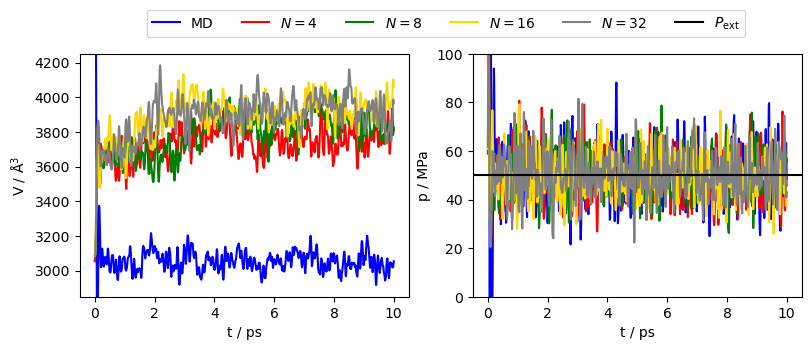

In [5]:
fig, ax = plt.subplots(1,2,constrained_layout=True, figsize=(8,3))
# Plot the cell volume
ax[0].plot(md_output["time"], md_output["volume"], 'b-', label="MD")
colours = ['r', 'g', 'gold', 'grey']
for nbeads, c in zip(sorted(pimd.keys()), colours):
    ax[0].plot(pimd[nbeads]["time"], pimd[nbeads]["volume"], c, label=rf"$N = {nbeads}$")
ax[0].set_ylim([2850, 4250])
ax[0].set_xlabel("t / ps")
ax[0].set_ylabel("V / Å$^3$")
# Plot the internal pressure and add a "shared" legend
lines = []
line, = ax[1].plot(md_output["time"], md_output["pressure_md"], 'b-', label="MD")
lines.append(line)
for nbeads, c in zip(sorted(pimd.keys()), colours):
    line, = ax[1].plot(pimd[nbeads]["time"], pimd[nbeads]["pressure_cv"], c, label=rf"$N = {nbeads}$")
    lines.append(line)
line = ax[1].axhline(50, color='k', label=r'$P_\text{ext}$')
lines.append(line)
fig.legend(handles=lines, ncols=len(lines), loc='lower center', bbox_to_anchor=(0.55, 1.0))
ax[1].set_ylim([0, 100])
ax[1].set_xlabel("t / ps")
ax[1].set_ylabel("p / MPa");

Pressure equilibrates rapidly to the target value of 50 MPa, but the equilibrium volume is much larger than that from the classical simulation, because of zero-point energy effects. At only 4 beads the volume is not quite converged, at least 8 beads are needed.

### Internal energy

In classical MD, the internal energy is the (thermal average) of the sum of potential and kinetic energies. In PIMD, one has to sum the *estimators* for the potential and kinetic energy *operators*. The potential-energy estimator is just the average over the beads,

$$
U_N = \frac{1}{N}\sum_{j=1}^{N} U(\mathbf{q}^{(j)})
$$

The kinetic energy, a non-linear function of the particle momenta, is trickier. The bead-averaged kinetic energy (`kinetic_md`) is **not** the correct estimator **except** for the case of $N = 1$. Instead, one can use the virial estimator [see [M. F. Herman, E. J. Bruskin, and B. J. Berne, J. Chem. Phys. 76, 5150 (1982)](http://dx.doi.org/10.1063/1.442815)], which converges nicely with bead number. 

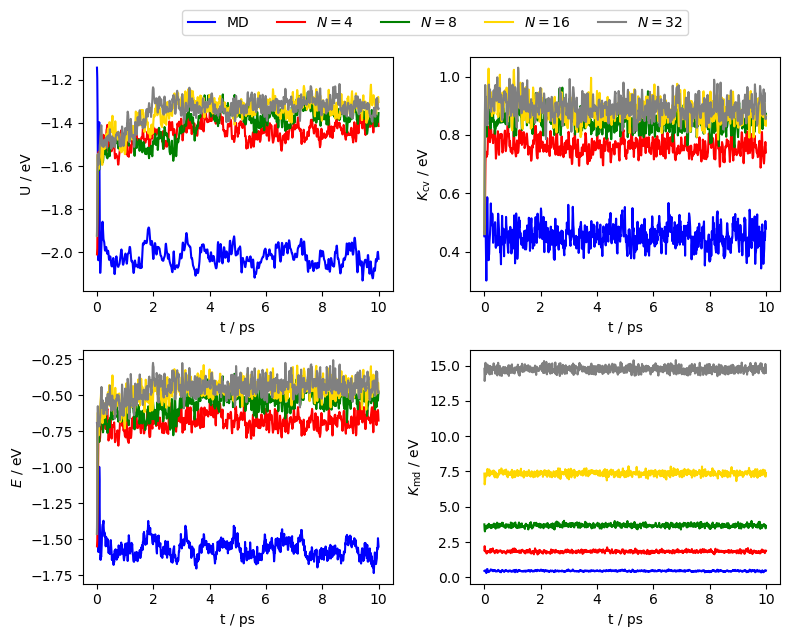

In [6]:
import numpy as np
fig, axarr = plt.subplots(2,2,figsize=(8,6))
ax = np.ravel(axarr)
# Potential energy
ax[0].plot(md_output["time"], md_output["potential"], 'b-', label="MD")
for nbeads, c in zip(sorted(pimd.keys()), colours):
    ax[0].plot(pimd[nbeads]["time"], pimd[nbeads]["potential"], c, label=rf"$N = {nbeads}$")
ax[0].set_xlabel("t / ps")
ax[0].set_ylabel("U / eV")
line, = ax[1].plot(md_output["time"], md_output["kinetic_md"], 'b-', label="MD")
lines = [line]
# Kinetic energy (virial)
for nbeads, c in zip(sorted(pimd.keys()), colours):
    line, = ax[1].plot(pimd[nbeads]["time"], pimd[nbeads]["kinetic_cv"], c, label=rf"$N = {nbeads}$")
    lines.append(line)
ax[1].set_xlabel("t / ps")
ax[1].set_ylabel(r"$K_{\text{cv}}$ / eV");
fig.legend(handles=lines, ncols=len(lines), loc='lower center', bbox_to_anchor=(0.55, 1.0));
# Internal energy (sum of the above)
ax[2].plot(md_output["time"], md_output["kinetic_md"] + md_output["potential"], 'b-', label="MD")
for nbeads, c in zip(sorted(pimd.keys()), colours):
    ax[2].plot(pimd[nbeads]["time"], pimd[nbeads]["kinetic_cv"] + pimd[nbeads]["potential"], c, label=rf"$N = {nbeads}$")
ax[2].set_xlabel("t / ps")
ax[2].set_ylabel(r"$E$ / eV");
# Kinetic energy (the wrong one)
ax[3].plot(md_output["time"], md_output["kinetic_md"], 'b-', label="MD")
for nbeads, c in zip(sorted(pimd.keys()), colours):
    line, = ax[3].plot(pimd[nbeads]["time"], pimd[nbeads]["kinetic_md"], c, label=rf"$N = {nbeads}$")
ax[3].set_xlabel("t / ps")
ax[3].set_ylabel(r"$K_{\text{md}}$ / eV");
fig.tight_layout();

The internal energy converges for $N = 16$, and its mean is substantially larger than in the classical simulation. The difference (about 10 meV per molecule) is a combination of zero-point energy effects and changes due to the expanded cell volume.

### Trajectory visualization

We can also display the ring-polymer trajectories, visualizing the "quantum swelling" of the hydrogen molecules.

In [7]:
# loads structures, on for every bead
warnings.filterwarnings('ignore', '.*residuenumbers array.*')
datadir = Path("pimd")  # change to "output" to load reference data
pi_frames = [ read(datadir/f'ph2-npt-pimd.pos_{i}.pdb', ":") for i in range(4) ]
frames = []
# At every time-step, join the structures from different bead indices into a single frame
for idx_f in range(len(pi_frames[0])):
    f = pi_frames[0][idx_f]
    for k in range(1,4):
        f += pi_frames[k][idx_f]
    f.wrap()
    f.info = {}
    f.arrays = {'positions': f.positions,  'numbers': f.numbers}
    frames.append(f)
chemiscope.show(frames=frames, 
                     properties={
                         "t" : { "values":  pimd[4]["time"][::10], "units": "ps", "target":"structure"},
                         "U" : { "values":  pimd[4]["potential"][::10], "units": "eV", "target":"structure"},
                         "V" : { "values":  pimd[4]["volume"][::10], "units": r"Å", "target":"structure"}
                     },
                     settings = {
                         'structure': [{ 'bonds': False, 
                                         'keepOrientation': True, 
                                         'unitCell': True,
                                         'playbackDelay': 20}],
                        'map': {'x': {'max': 10,  'min': -0.25, 'property': 't', 'scale': 'linear'},
                                'y': {'max': 4000,  'min': 3000, 'property': 'V', 'scale': 'linear'},
                                 'color': {'property': 'U'}
                               }
                     })

<ChemiscopeWidget(meta={'name': ' '}, settings={'structure': [{'bonds': False, 'keepOrientation': True, 'unitC…

### Density calculation

Given the mean cell volume after equilibration and the mass of the atoms in the supercell, we can calculate the density of solid hydrogen and compare to the experimental result. At 33 K and 50 MPa the density is around 90 kg/m<sup>3</sup> [[ILK Dresden, M. Kuhn](https://www.ilkdresden.de/leistungen/forschung-und-entwicklung/projekt/wasserstoff-und-methan-versuchsfeld-am-ilk)], which is very close to the converged PIMD result.

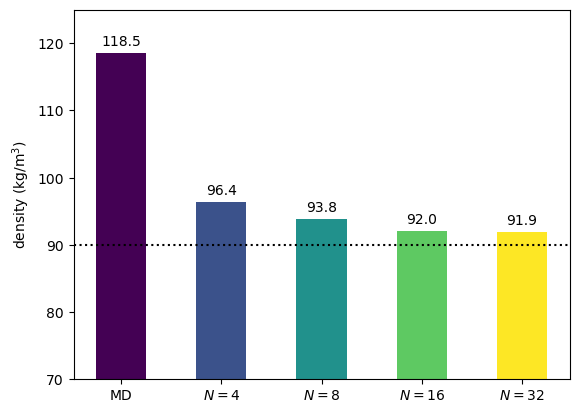

In [8]:
from ipi.utils import units
from matplotlib import cm
pimd[1] = md_output # for convenience
nmols = len(frames[0]) // 4  # number of molecules = total number of particles in a frame divided by number of beads
m_tot = units.Elements.mass("H")*2 * nmols # mass of all H2 molecules in atomic units
nbeads = [1, 4, 8, 16, 32]
volumes = []
cutoff = 5 # equilbaration time in ps - safe choice for all our trajectories
for N in nbeads:
    mask = pimd[N]["time"] > cutoff
    volumes.append(np.mean(pimd[N]["volume"][mask]))
# mass is in internal (atomic) units - convert volume from AA^3 to internal units as well
volumes = units.unit_to_internal("volume", "angstrom3", np.asarray(volumes))
# density, converted from internal units
densities = units.unit_to_user("density", "g/cm3", m_tot / volumes)
densities *= 1000 # g/cm3 -> kg/m^3
# visualize the results as a bar plot
fig, ax = plt.subplots()
labels = ['MD'] + [f"$N = {N}$" for N in nbeads[1:]]
cmap = plt.get_cmap("viridis")
bar_colors = cmap(np.linspace(0,1,len(densities))).tolist() 
p = ax.bar(labels, densities, color=bar_colors, width=0.5);
ax.bar_label(p, padding=3, fmt='%.1f')
ax.axhline(90.0, c='k', ls=':')
ax.set_ylabel('density (kg/m$^3$)')
ax.set_ylim([70,125]);